## Figure S7B

In [1]:
# Preliminaries to work with the data.   
%matplotlib inline
%run __init__.py
from utils import loading, scoring
from gerkin import dream,params,fit2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib as mpl
mpl.rcParams.update({'font.size':14})

In [5]:
# Load the data
descriptors = loading.get_descriptors(format='True')
all_CIDs = loading.get_CIDs(['training','leaderboard','testset'])
testset_CIDs = loading.get_CIDs(['testset'])
all_CID_dilutions = loading.get_CID_dilutions(['training','leaderboard','testset'])
#mdx_full = dream.get_molecular_data(['dragon','episuite','morgan','nspdk','gramian'],all_CIDs)
features = loading.get_molecular_data(['dragon','morgan'],all_CIDs)

Dragon has 4869 features for 476 molecules.
Morgan has 2437 features for 476 molecules.
There are now 7306 total features.


In [41]:
# Create the feature and descriptor arrays 
X,_,_,_,_,_ = dream.make_X(features,all_CID_dilutions)
X_train = X.drop(testset_CIDs)
X_test = X.drop(X_train.index)

The X matrix now has shape (814x5519) molecules by non-NaN good molecular descriptors


In [32]:
Y_train = loading.load_perceptual_data(['training','leaderboard'])
Y_train = Y_train.groupby(level=['Descriptor','CID','Dilution']).mean() # Average over replicates
Y_test = loading.load_perceptual_data('testset')

### Load or compute the random forest model

In [62]:
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor

n_subjects = 49
n_splits = 25
trans_params = params.get_trans_params(Y_train, descriptors, plot=False)
use_et, max_features, max_depth, min_samples_leaf, trans_weight, regularize, use_mask = params.get_other_params()
ss = ShuffleSplit(n_splits=n_splits,test_size=(24./49),random_state=0)
rs_in = pd.DataFrame(index=range(n_splits),columns=descriptors) # Same subject, different molecules correlations.  
rs_out = pd.DataFrame(index=range(n_splits),columns=descriptors) # Different subject, different molecule correlations.
for d,descriptor in enumerate(descriptors):
    print("%d) %s" % (d,descriptor))
    rfc = RandomForestRegressor(n_estimators=3, max_features='auto', random_state=0)
    for i,(train,test) in enumerate(ss.split(range(n_subjects))):
        train+=1; test+=1; # Subjects are 1-indexed.  
        print("\tFitting split %d" % i)
        rfc.fit(X_train,Y_train['Subject'][train].mean(axis=1).loc[descriptor])
        Y_test_in = Y_test['Subject'][train].mean(axis=1).loc[descriptor]
        Y_test_out = Y_test['Subject'][test].mean(axis=1).loc[descriptor]
        Y_predicted = rfc.predict(X_test)
        rs_in.loc[i,descriptor] = np.corrcoef(Y_predicted,Y_test_in)[0,1]
        rs_out.loc[i,descriptor] = np.corrcoef(Y_predicted,Y_test_out)[0,1]

0) Intensity
	Fitting split 0
	Fitting split 1
	Fitting split 2
	Fitting split 3


KeyboardInterrupt: 

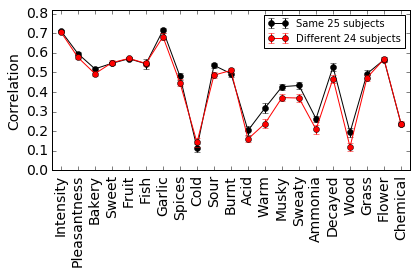

In [269]:
# 25 x 30
fig,axes = plt.subplots(2,2)
ax = axes.flat
ax[0].errorbar(range(len(descriptors)),rs_in.mean(),yerr=rs_in.sem(),
             color='k',fmt='o-',label='Same %d subjects' % 25)
ax[0].errorbar(range(len(descriptors)),rs_out.mean(),yerr=rs_out.sem(),
             color='r',fmt='o-',label='Different %d subjects' % 24)
order = rs_in4.mean().rank()[::-1]
ax[1].errorbar(range(len(descriptors)),rs_in.mean()[order],yerr=(rs_in.sem()[order],
             color='k',fmt='o-',label='Same %d subjects' % 25)
ax[1].errorbar(range(len(descriptors)),rs_out.mean()[order],yerr=(rs_out.sem()[order],
             color='r',fmt='o-',label='Different %d subjects' % 24)
ax[2].errorbar(rs_in.mean(),rs_out.mean(),
             xerr=rs_in.sem(),yerr=rs_out.sem(),
             color='k',fmt='o')
ax[2].plot([0,1],[0,1],'--')
ax[2].xlim(0,0.82)
ax[2].xlabel('Correlation\n(Same 25 subjects)')
ax[2].ylabel('Correlation\n(Different 25 subjects)')
order = (rs_in4.mean()-rs_out.mean()).rank()[::-1]
ax[3].errorbar(len(descriptors,(rs_in-rs_out).mean()[order],
             yerr=(rs_in4-rs_out4).sem()[order],
             color='k',fmt='o-')
ax[3].plot([0,len(descriptors)],[0,0],'--')
ax[3].xlim(-0.5,len(descriptors)-0.5)
ax[3].ylim(-0.05,0.1)
ax[3].xticks(len(descriptors),np.array(descriptors)[order],rotation=90);
ax[3].ylabel('Correlation Difference')

for i in [0,1]:
    plt.xlim(-0.5,len(descriptors)-0.5)
    plt.ylim(0,0.82)
    plt.xticks(range(len(descriptors)),descriptors,rotation=90);
    plt.ylabel('Correlation')
    plt.legend(fontsize=10)

plt.tight_layout()
plt.savefig('../../figures/subject-splits.eps',format='eps')

In [191]:
print('%.3f +/- %.3f, with maximum value %.3f' % \
      ((rs_in-rs_out).mean().mean(),(rs_in-rs_out).mean().std(),(rs_in-rs_out).mean().max()))
from scipy.stats import ttest_rel,chi2
# No FDR correction
chi2_ = 0
for d,descriptor in enumerate(descriptors):
    p = ttest_rel(rs_in.mean()[descriptor],rs_out,mean()[descriptor])[1]
    chi2_ += -2*np.log(p)
    print('%s%.3f' % ((descriptor+':').ljust(15),p))
p_pooled = 1-chi2.cdf(chi2_,2*len(descriptors))
print("Pooled p-value = %.3g" % p_pooled)

0.027 +/- 0.031, with maximum value 0.079
Intensity:     0.257
Pleasantness:  0.066
Bakery:        0.319
Sweet:         0.804
Fruit:         0.858
Fish:          0.954
Garlic:        0.030
Spices:        0.007
Cold:          0.350
Sour:          0.025
Burnt:         0.348
Acid:          0.076
Warm:          0.023
Musky:         0.010
Sweaty:        0.002
Ammonia:       0.014
Decayed:       0.064
Wood:          0.012
Grass:         0.175
Flower:        0.891
Chemical:      0.944
Pooled p-value = 1.09e-06


In [197]:
from scipy.io import loadmat
gs6 = loadmat('../../data/gs6.mat')['gs']

In [231]:
rfc = RandomForestRegressor(n_estimators=30, max_features='auto', random_state=0)
ss = ShuffleSplit(49,n_iter=n_splits,test_size=(6./49),random_state=0)
rs_in5 = np.zeros((21,n_splits))
rs_out5 = np.zeros((21,n_splits))
for col in range(21):
    print("Descriptor %d" % col)
    X_test = X_test_int if col==0 else X_test_other
    for i,(train,test) in enumerate(ss):
        train+=1; test+=1
        print("Fitting split %d" % i)    
        Y_train,imputer = dream.make_Y_obs(['training','leaderboard'],imputer='mask',subjects=train,quiet=True)
        Y_test_in,imputer = dream.make_Y_obs(['testset'],target_dilution=-3 if col==0 else 'high',imputer='mask',subjects=test,quiet=True)
        Y_test_out = np.ma.array(gs6,mask=np.isnan(gs6))
        rfc.fit(X_train,Y_train['mean_std'][:,col])
        Y_predicted = rfc.predict(X_test)
        rs_in5[col,i] = np.ma.corrcoef(Y_predicted,Y_test_in['mean_std'][:,col])[0,1]
        rs_out5[col,i] = np.ma.corrcoef(Y_predicted,Y_test_out[:,col])[0,1]        

Descriptor 0
Fitting split 0
Fitting split 1
Fitting split 2
Fitting split 3
Fitting split 4
Fitting split 5
Fitting split 6
Fitting split 7
Fitting split 8
Fitting split 9
Fitting split 10
Fitting split 11
Fitting split 12
Fitting split 13
Fitting split 14
Fitting split 15
Fitting split 16
Fitting split 17
Fitting split 18
Fitting split 19
Fitting split 20
Fitting split 21
Fitting split 22
Fitting split 23
Fitting split 24
Descriptor 1
Fitting split 0
Fitting split 1
Fitting split 2
Fitting split 3
Fitting split 4
Fitting split 5
Fitting split 6
Fitting split 7
Fitting split 8
Fitting split 9
Fitting split 10
Fitting split 11
Fitting split 12
Fitting split 13
Fitting split 14
Fitting split 15
Fitting split 16
Fitting split 17
Fitting split 18
Fitting split 19
Fitting split 20
Fitting split 21
Fitting split 22
Fitting split 23
Fitting split 24
Descriptor 2
Fitting split 0
Fitting split 1
Fitting split 2
Fitting split 3
Fitting split 4
Fitting split 5
Fitting split 6
Fitting split 7
Fit

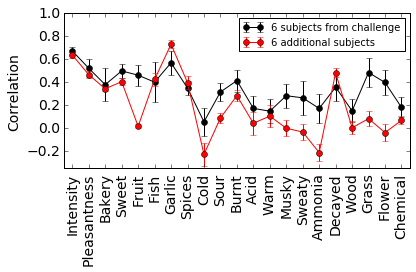

In [261]:
plt.errorbar(range(21),rs_in5.mean(axis=1),yerr=rs_in5.std(axis=1),color='k',fmt='o-',label='6 subjects from challenge')
plt.errorbar(range(21),rs_out5.mean(axis=1),yerr=rs_out5.std(axis=1),color='r',fmt='o-',label='6 additional subjects')
plt.xlim(-0.5,20.5)
plt.ylim(-0.35,1)
plt.xticks(range(21),descriptors,rotation=90);
plt.ylabel('Correlation')
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('/Users/rgerkin/Desktop/6in_vs_6out_model_prediction.eps',format='eps')

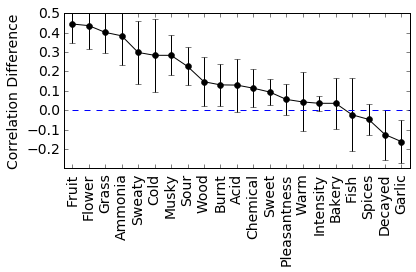

In [239]:
order = np.argsort(rs_in5.mean(axis=1)-rs_out5.mean(axis=1))[::-1]
plt.errorbar(range(21),(rs_in5-rs_out5).mean(axis=1)[order],
             yerr=(rs_in5-rs_out5).std(axis=1)[order],
             color='k',fmt='o-')
plt.plot([0,21],[0,0],'--')
plt.xlim(-0.5,20.5)
plt.ylim(-0.3,0.5)
plt.xticks(range(21),np.array(descriptors)[order],rotation=90);
plt.ylabel('Correlation Difference')
plt.tight_layout()

In [247]:
rs_in6 = np.zeros((21,n_splits))
rs_out6 = np.zeros((21,n_splits))
for col in range(21):
    print("Descriptor %d" % col)
    for i,(train,test) in enumerate(ss):
        train+=1; test+=1
        print("Calculating split %d" % i)    
        Y_test,imputer = dream.make_Y_obs(['testset'],target_dilution=-3 if col==0 else 'high',imputer='mask',subjects=train,quiet=True)
        Y_test_in,imputer = dream.make_Y_obs(['testset'],target_dilution=-3 if col==0 else 'high',imputer='mask',subjects=test,quiet=True)
        Y_test_out = np.ma.array(gs6,mask=np.isnan(gs6))
        rs_in6[col,i] = np.ma.corrcoef(Y_test['mean_std'][:,col],Y_test_in['mean_std'][:,col])[0,1]
        rs_out6[col,i] = np.ma.corrcoef(Y_test['mean_std'][:,col],Y_test_out[:,col])[0,1]

Descriptor 0
Calculating split 0
Calculating split 1
Calculating split 2
Calculating split 3
Calculating split 4
Calculating split 5
Calculating split 6
Calculating split 7
Calculating split 8
Calculating split 9
Calculating split 10
Calculating split 11
Calculating split 12
Calculating split 13
Calculating split 14
Calculating split 15
Calculating split 16
Calculating split 17
Calculating split 18
Calculating split 19
Calculating split 20
Calculating split 21
Calculating split 22
Calculating split 23
Calculating split 24
Descriptor 1
Calculating split 0
Calculating split 1
Calculating split 2
Calculating split 3
Calculating split 4
Calculating split 5
Calculating split 6
Calculating split 7
Calculating split 8
Calculating split 9
Calculating split 10
Calculating split 11
Calculating split 12
Calculating split 13
Calculating split 14
Calculating split 15
Calculating split 16
Calculating split 17
Calculating split 18
Calculating split 19
Calculating split 20
Calculating split 21
Calcula

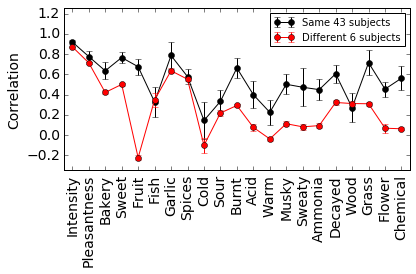

In [262]:
plt.errorbar(range(21),rs_in6.mean(axis=1),yerr=rs_in6.std(axis=1),color='k',fmt='o-',label='Same %d subjects' % len(train))
plt.errorbar(range(21),rs_out6.mean(axis=1),yerr=rs_out6.std(axis=1),color='r',fmt='o-',label='Different %d subjects' % len(test))
plt.xlim(-0.5,20.5)
plt.ylim(-0.35,1.25)
plt.xticks(range(21),descriptors,rotation=90);
plt.ylabel('Correlation')
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('/Users/rgerkin/Desktop/6in_vs_6out_only_data.eps',format='eps')

<Container object of 3 artists>

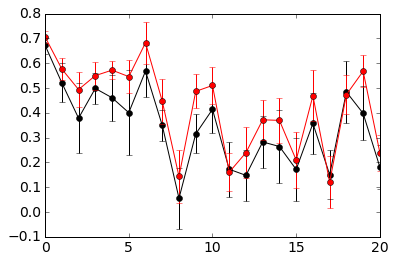

In [265]:
plt.errorbar(range(21),rs_in5.mean(axis=1),yerr=rs_in5.std(axis=1),color='k',fmt='o-',label='6 subjects from challenge')
plt.errorbar(range(21),rs_out4.mean(axis=1),yerr=rs_out4.std(axis=1),color='r',fmt='o-',label='6 subjects from challenge')